<a href="https://colab.research.google.com/github/CadeHarger/portfolio/blob/main/Personal_Projects/Trump_Speech_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
#@title Import Relevant Modules
import random
import time
import math
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
#@title Extract Speech
speeches = []
with open("temp.txt", 'r') as oldSpeeches:
  speeches = [line for line in oldSpeeches]
oldSpeeches.close()
for line in speeches:
  if (not line == '\n') and (not line[0] == ' ') and (not line == 'Donald Trump\n') and (not line[0] == '0') and (not line[0] == '1'):
    print(line.replace("\n", " "), end="")

In [ ]:
#@title Load the Dataset (Speeches + Tweets)

# Read the files
speeches = []
with open("ALLJune2015-November92016.txt", 'r') as oldSpeeches:
  speeches = [line for line in oldSpeeches]
oldSpeeches.close()
with open("ALLJuly2019-Nov2020.txt", 'r') as newSpeeches:
  for line in newSpeeches:
    speeches.append(line)
newSpeeches.close()
with open("CollectedSpeech.txt", 'r') as collected:
  for line in collected:
    speeches.append(line)
collected.close()
with open("ALLPersonallyCollectedSpeeches.txt", 'r') as collectedSpeeches:
  for line in collectedSpeeches:
    speeches.append(line)
collectedSpeeches.close()
speeches = np.array(speeches)


# Load the tweets too (w/ extra selectivity)
csv = pd.read_csv("ALLTrumpTweetsuntilJan82021.csv")
rawData = csv['text'].to_numpy()
del csv

rawData = np.array([rawData[x] for x in range(len(rawData)) if not '@' in rawData[x]])

# Remove links, other undesirable data
for data in range(len(rawData)):
  original = rawData[data].split()
  rawData[data] = ' '.join([((original[word].replace('.',' . ')).replace('  ',' ')).replace('  ',' ') for word in range(len(original)) if not ('http' in original[word] or 'twitter.co' in original[word] or 'ا' in original[word] or 'ل' in original[word] or '.com/' in original[word] or '#' in original[word])])
speeches = np.append(speeches, rawData)
del rawData

np.random.shuffle(speeches)

# Remove undesirable data
for data in range(len(speeches)):
  original = speeches[data].split()
  temp = [original[word] for word in range(len(original)) if not ('inaudible' in original[word] or 'twitter.co' in original[word])]
  speeches[data] = np.array(' '.join([word.replace('. . .', '...').replace('... ...', '...') for word in temp]))

# Convert text data to word indexes
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None,
                     filters='“”#$%&()*+-<=>\\^_`{|}~\t\n\"',
                     lower = True, split = ' ')
tokenizer.fit_on_texts(speeches)
dataset = tokenizer.texts_to_sequences(speeches)
del speeches
wordIndexes = tokenizer.index_word
numWords = len(wordIndexes) + 1
del tokenizer

trainSize =  16 #@param{type: "integer"}
testSize = 5000 #@param{type: "integer"}
#noiseCount = 10000 #@param{type: "integer"}

# Split the dataset into features
featureSet = []
labelSet = []
for speech in dataset:
  if len(speech) > trainSize:
    pieces = [speech[x:x + trainSize + 1] for x in range(0, len(speech) - (trainSize + 1), trainSize + 1)]
    for data in pieces:
      featureSet.append(data[:-1])
      labelSet.append(data[-1])

'''
# Add more features by splitting the previous examples in half
for speech in dataset[:-1 * testSize / ]:
  if len(speech) > trainSize + math.ceil(trainSize / 2):
    pieces = [speech[x:x + trainSize + 1] for x in range(math.ceil(trainSize / 2), len(speech) - (trainSize + 1), trainSize + 1)]
    for data in pieces:
      featureSet.append(data[:-1])
      labelSet.append(data[-1])


# Add noise to the dataset
print(wordIndexes[numWords - 1])
for x in range(noiseCount):
  featureSet.append([random.randint(1, numWords) for y in range(trainSize)])
  labelSet.append(numWords)
wordIndexes[numWords] = 'RANDOM_NOISE'
numWords += 1
print(wordIndexes[numWords - 1])
'''

featureSet = np.array(featureSet)
tempLabelSet = np.array(labelSet)

# One-hot encode the labelSet
labelSet = np.zeros((len(featureSet), numWords), dtype=np.int8)
for exampleIndex, wordIndex in enumerate(tempLabelSet):
  labelSet[exampleIndex, wordIndex] = 1
del tempLabelSet

testFeatureSet = featureSet[-1 * testSize:]
testLabelSet = labelSet[-1 * testSize:]
featureSet = featureSet[:-1 * testSize]
labelSet = labelSet[:-1 * testSize]

In [ ]:
print(featureSet.shape, labelSet.shape, numWords)

(82195, 16) (82195, 22617) 22617


In [ ]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics, oldHist=None, oldMetrics=None):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  if oldHist is not None:
    for m in oldMetrics:
      x = oldHist[m]
      plt.plot(epochs[1:], x[1:], label=m + 'OLD')

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [ ]:
#@title Model Training
def trainModel(model, features, label, epochs,
                batchSize=None, validationSplit=0.1):

  # Split the dataset into features and label.
  #features = {name:np.array(value) for name, value in dataset.items()}
  #label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batchSize,
                      epochs=epochs, shuffle=True, validation_split=validationSplit)

  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist

In [ ]:
#@title Model Creation
def createModel(lr):
  #model = tf.keras.models.Sequential()
  input = tf.keras.layers.Input(shape=(trainSize,))
  embed = tf.keras.layers.Embedding(input_dim=numWords,
                input_length = trainSize,
                output_dim=300,
                trainable=True)(input)

  # Masking layer for pre-trained embeddings
  #model.add(tf.keras.layers.Masking(mask_value=0.0))

  x = tf.keras.layers.LSTM(200, return_sequences=False,
                dropout=0.3, recurrent_dropout = 0.3)(embed)

  x = tf.keras.layers.Dense(200, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Dense(numWords, activation='softmax')(x)
  model = tf.keras.Model(inputs=input, outputs=x)
  embedModel = tf.keras.Model(inputs=input, outputs=embed)

  model.compile(
      optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model, embedModel

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 16, 300)           6785100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 22617)             4546017   
Total params: 11,772,117
Trainable params: 11,772,117
Non-trainable params: 0
_______________________________________________

[7.064932823181152, 0.14100000262260437]

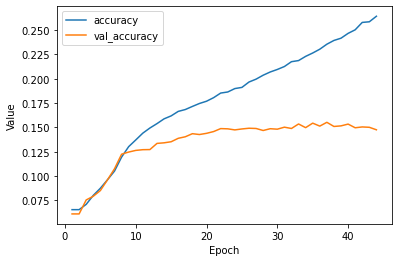

In [ ]:
#@title The AI

lr = 0.003
epochs = 45
batchSize = 1024
validationSplit = 0.1

model, embeddingLayer = createModel(lr)
model.summary()

epochs, hist = trainModel(model, featureSet, labelSet, epochs, batchSize, validationSplit)
metrics = ['accuracy', 'val_accuracy']
plot_curve(epochs, hist, metrics)

print("Evaluate Model on Test Set:")
model.evaluate(x = testFeatureSet, y = testLabelSet, batch_size=batchSize)

In [ ]:
#@title Store Graph
oldHist, oldMetrics = hist, metrics

In [ ]:
#@title Compare Graph
plot_curve(epochs, hist, metrics, oldHist, oldMetrics)

NameError: ignored

In [ ]:
#@title Data Frequency
freq = np.zeros((numWords), dtype = np.int32)
for data in dataset:
  for word in data:
    freq[word] += 1
print(freq[1:100])
print(sum(freq))
print(np.where(freq == 1))

[114744  91354  60623  45258  38361  28710  27947  24127  21463  21174
  20270  20038  18454  17181  16564  15424  14012  13000  12747  10882
  10287   9822   9664   8791   8762   8642   8348   8216   8106   7793
   7647   7620   7171   6902   6764   6741   6144   5922   5303   5293
   5197   4768   4761   4520   4497   4408   4369   4314   4237   4166
   4151   4103   4101   4043   4021   4015   3915   3905   3853   3839
   3803   3778   3756   3733   3656   3526   3406   3300   3297   3289
   3254   3206   3187   3148   3086   3039   3003   2997   2994   2940
   2934   2898   2888   2837   2834   2826   2782   2782   2753   2699
   2686   2685   2672   2568   2565   2530   2520   2503   2450]
1683234
(array([14516, 14517, 14518, ..., 22614, 22615, 22616]),)


In [ ]:
#@title Count Entries
searchFor = 'brady' #@param {type: "string"}
shoudPrint = True #@param {type: "boolean"}
showCount = True #@param {type: "boolean"}
count = 0
for x in range(1, len(wordIndexes)):
  if searchFor in wordIndexes[x]:
    count += 1
    if shoudPrint:
      print(wordIndexes[x], x, end="  ")
      if showCount:
        print(freq[x - 1], end="")
      print()
print(count)

brady 3613  

NameError: ignored

In [ ]:
#@title Generate New Data
# continueFor: number of words for the AI to write
# samples: the number of starting phrases
# variance: the number of standard deviations of the possibility probabilities to modify the probability when predicting the next word. 0 = always predict the most likely word
continueFor = 100
samples = 1
variance = 76 #@param {type:"slider", min:0, max:200, step:2}

startIndex = samples + random.randint(0,100)
for count in range(startIndex, startIndex + samples):
  print()
  seed = testFeatureSet[count:count + 1].copy()
  for word in seed[0]:
    print(wordIndexes[word], end=" ")
  print('*** ')
  for x in range(continueFor):
    output = model.predict(seed)
    output = np.add(output, (np.random.rand(output.shape[1]) - 0.5) * np.std(output) * 2 * variance) # Adds variance
    index = np.argmax(output[0])
    print(wordIndexes[index], end=" ")
    for y in range(trainSize - 1):
      seed[0][y] = seed[0][y + 1]
    seed[0][-1] = index
    if (x + 1) % 20 == 0:
      print()


i am not trying to get top level security clearance for my children . this was *** 
systematically lord hour in prison . and creed , we are going to destroy the united states . i want 
to make it . you know , they're going to be anything in the world . i said , he 
's going to be able to be looking at a good thing . they just said , i said , 
it 's going to do it . i think that they have to make america great again . it 's 
a great job , and i want to do that , i think there 's true . but i think 


In [ ]:
print(wordIndexes)
print([wordIndexes[x] for x in range(1, 20)])

Remove @names with one mention (15k+)?

do not -> don't, would not -> wouldn't (not every)

import tweets without @s

WordChars: ". , $ ! ? / % -"

Semicolons?, Colons in nontweets?

[ when touching chars, No "uh", "um", "ah", "hmm"

separate 's into words

.

.

HIGH SCORE: 16.55 (21.13 test with 5)

200 LSTM 2x0.3 Dropout

200 Dense 0.5 Dropout

lr = 0.003

Test = 5000, VS = 0.1

23363 words,

size = 16, dim = 300 (standard)


(22608, 300)


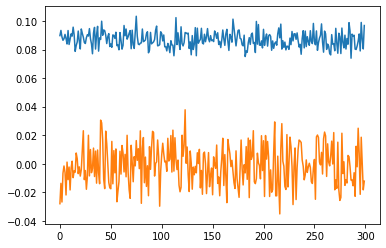

In [ ]:
#@title View Embedding
everyWord = np.array([embeddingLayer(np.arange(x, x + trainSize)) for x in range(int(numWords / trainSize))])
allWords = np.reshape(everyWord, (everyWord.shape[0] * everyWord.shape[1], everyWord.shape[-1]))
print(allWords.shape)
plt.plot(np.std(allWords, 0))
plt.plot(np.mean(allWords, 0))

